In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[1 1 0 1 1 0 0 1 1 2 0 0 0 0 0 0 2 0 0 0 0 1 1 1 2 1 1 0 1 0 2 0]


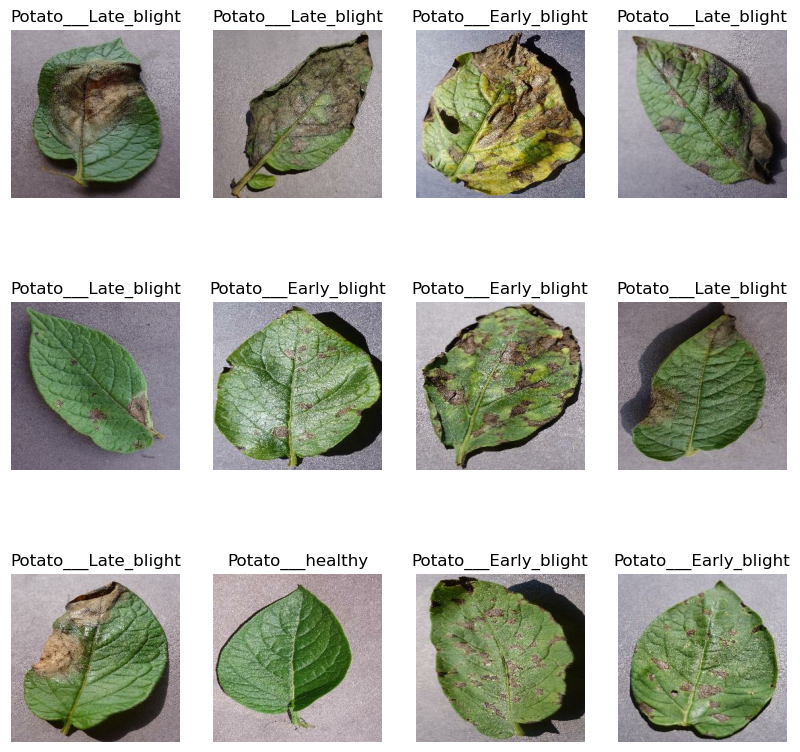

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
54/54 [==============================] - 77s 1s/step - loss: 0.8711 - accuracy: 0.4786 - val_loss: 0.8051 - val_accuracy: 0.5990
Epoch 2/20
54/54 [==============================] - 71s 1s/step - loss: 0.6505 - accuracy: 0.6962 - val_loss: 0.7046 - val_accuracy: 0.6667
Epoch 3/20
54/54 [==============================] - 71s 1s/step - loss: 0.4701 - accuracy: 0.7975 - val_loss: 0.3949 - val_accuracy: 0.8281
Epoch 4/20
54/54 [==============================] - 70s 1s/step - loss: 0.3333 - accuracy: 0.8681 - val_loss: 0.3000 - val_accuracy: 0.8750
Epoch 5/20
54/54 [==============================] - 70s 1s/step - loss: 0.2189 - accuracy: 0.9190 - val_loss: 0.2650 - val_accuracy: 0.8854
Epoch 6/20
54/54 [==============================] - 71s 1s/step - loss: 0.2525 - accuracy: 0.8958 - val_loss: 0.2257 - val_accuracy: 0.9219
Epoch 7/20
54/54 [==============================] - 83s 2s/step - loss: 0.1859 - accuracy: 0.9236 - val_loss: 0.2776 - val_accuracy: 0.8906
Epoch 8/20
54/54 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 5s 242ms/step - loss: 0.1412 - accuracy: 0.9492


[0.14118511974811554, 0.94921875]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8710631132125854,
 0.6504501700401306,
 0.4700615406036377,
 0.33331844210624695,
 0.2189217358827591,
 0.252494752407074,
 0.18594731390476227,
 0.2093828320503235,
 0.17550477385520935,
 0.18193084001541138,
 0.15066494047641754,
 0.10916711390018463,
 0.08857881277799606,
 0.12676654756069183,
 0.09533115476369858,
 0.0841243639588356,
 0.08617342263460159,
 0.05945254862308502,
 0.13246046006679535,
 0.04767446592450142]

In [16]:
history.history['accuracy']

[0.47858795523643494,
 0.6961805820465088,
 0.7974537014961243,
 0.8680555820465088,
 0.9189814925193787,
 0.8958333134651184,
 0.9236111044883728,
 0.9178240895271301,
 0.9288194179534912,
 0.9299768805503845,
 0.9409722089767456,
 0.9652777910232544,
 0.9641203880310059,
 0.9565972089767456,
 0.9629629850387573,
 0.9652777910232544,
 0.96875,
 0.9809027910232544,
 0.9508101940155029,
 0.9826388955116272]

In [17]:
history.history['val_loss']

[0.8050634264945984,
 0.704587459564209,
 0.39487627148628235,
 0.2999936044216156,
 0.2649616599082947,
 0.22574728727340698,
 0.27764275670051575,
 0.2791070342063904,
 0.18766938149929047,
 0.20620481669902802,
 0.17766761779785156,
 0.2735240161418915,
 0.10290184617042542,
 0.126722052693367,
 0.10770844668149948,
 0.10671854764223099,
 0.09681171923875809,
 0.52842777967453,
 0.11284255981445312,
 0.09611684083938599]

In [18]:
history.history['val_accuracy']

[0.5989583134651184,
 0.6666666865348816,
 0.828125,
 0.875,
 0.8854166865348816,
 0.921875,
 0.890625,
 0.90625,
 0.9166666865348816,
 0.9166666865348816,
 0.9322916865348816,
 0.90625,
 0.9635416865348816,
 0.9479166865348816,
 0.9479166865348816,
 0.9479166865348816,
 0.96875,
 0.8229166865348816,
 0.9583333134651184,
 0.9583333134651184]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

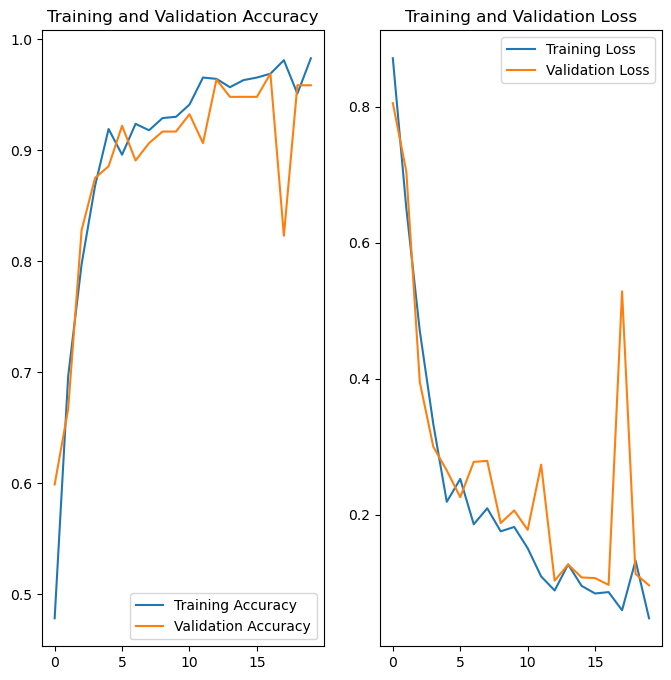

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 325ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


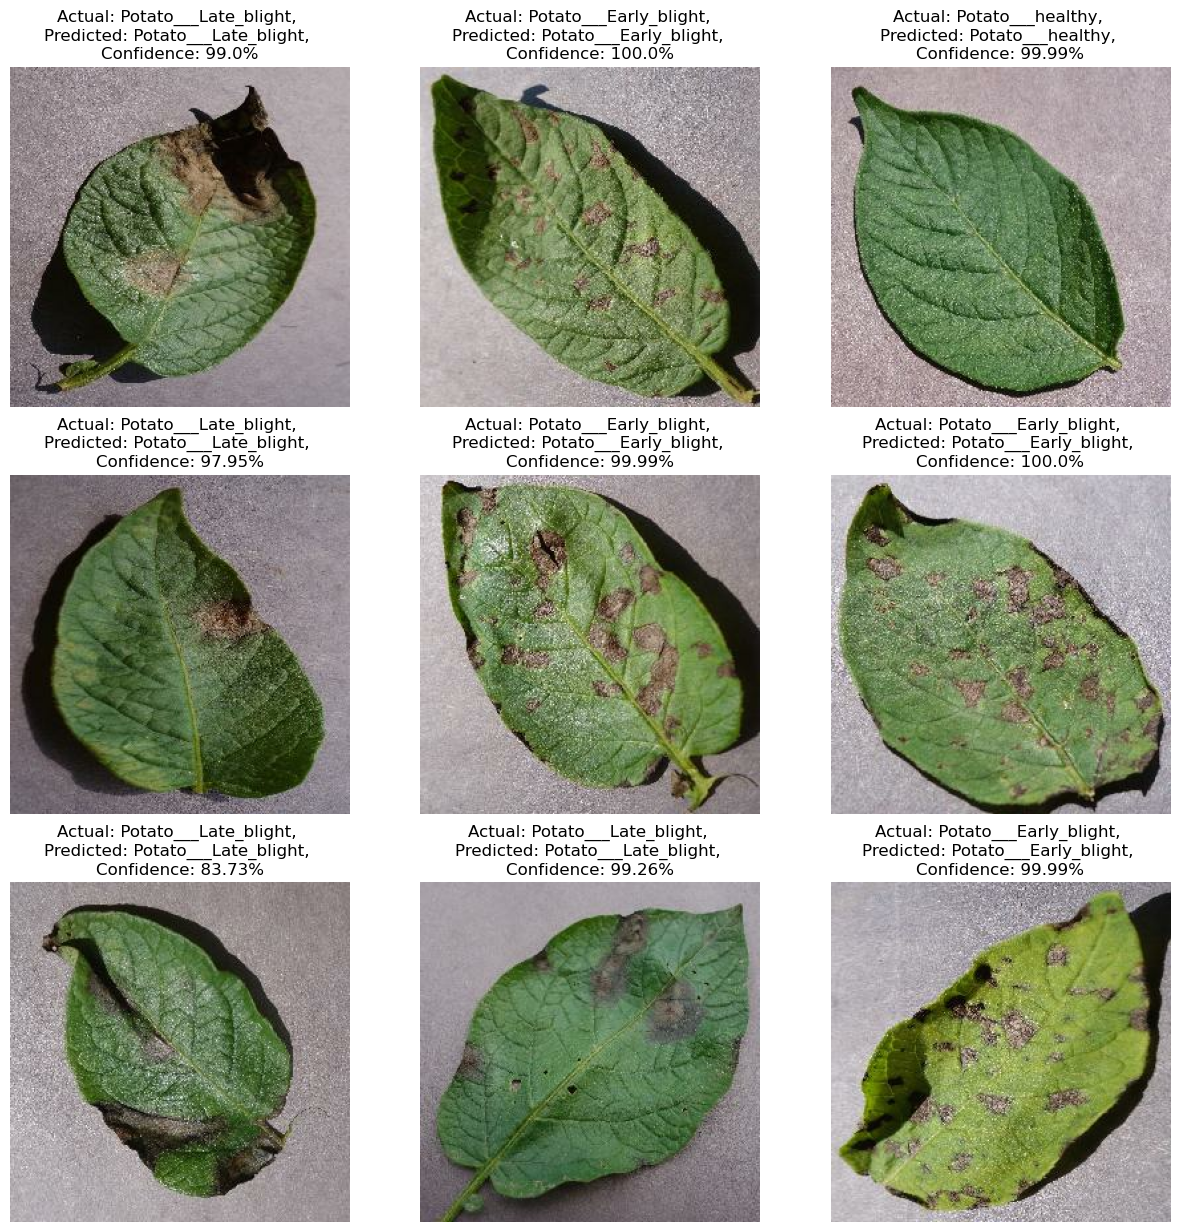

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       116
           1       1.00      0.89      0.94       119
           2       0.91      1.00      0.95        21

    accuracy                           0.95       256
   macro avg       0.94      0.96      0.95       256
weighted avg       0.95      0.95      0.95       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[116,   0,   0],
       [ 11, 106,   2],
       [  0,   0,  21]])>

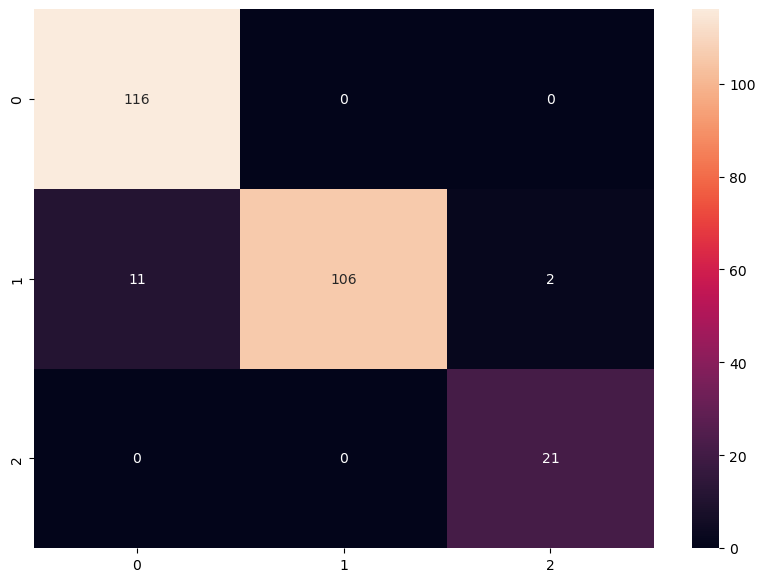

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-DatasetSplit80-10-10.joblib"
joblib.dump(model, filename)

['Model1-DatasetSplit80-10-10.joblib']